In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [23]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [13]:
import requests
import io
test_values = requests.get("https://s3.amazonaws.com/drivendata/data/54/public/test_values.csv").content
train_values = requests.get("https://s3.amazonaws.com/drivendata/data/54/public/train_values.csv").content
train_labels = requests.get("https://s3.amazonaws.com/drivendata/data/54/public/train_labels.csv").content
X = pd.read_csv(io.StringIO(train_values.decode('utf-8')))
y = pd.read_csv(io.StringIO(train_labels.decode('utf-8')))

Categorical features and label encoding

In [14]:
X.thal = X['thal'].astype('category')
X = pd.concat([X, pd.get_dummies(X.thal, 'thal', drop_first=True)], axis=1)
X = X.drop(['thal'], axis=1)

y.heart_disease_present = y.heart_disease_present.astype('category')

In [15]:
df = pd.merge(left=X, right=y, how='left', on='patient_id')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['patient_id', 'heart_disease_present'], axis=1), df.heart_disease_present, test_size=.3, stratify=df.heart_disease_present)

Setup the neural network

In [29]:
n_rows, n_cols = X_train.shape
scaler = StandardScaler()
Xnp = scaler.fit_transform(X_train)
Xnp = Xnp.reshape(-1, n_cols)
Ynp = pd.get_dummies(y_train).values

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(n_cols, )))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=2)

In [35]:
model.fit(Xnp, Ynp, epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
126/126 [==============================] - 0s 111us/step - loss: 0.1085 - accuracy: 0.9603
Epoch 2/50
126/126 [==============================] - 0s 103us/step - loss: 0.0985 - accuracy: 0.9603
Epoch 3/50
126/126 [==============================] - 0s 95us/step - loss: 0.0972 - accuracy: 0.9683
Epoch 4/50
126/126 [==============================] - 0s 103us/step - loss: 0.1143 - accuracy: 0.9524
Epoch 5/50
126/126 [==============================] - 0s 87us/step - loss: 0.1744 - accuracy: 0.9365
Epoch 6/50
126/126 [==============================] - 0s 87us/step - loss: 0.0997 - accuracy: 0.9762
Epoch 7/50
126/126 [==============================] - 0s 103us/step - loss: 0.1047 - accuracy: 0.9603
Epoch 8/50
126/126 [==============================] - 0s 151us/step - loss: 0.1115 - accuracy: 0.9683
Epoch 9/50
126/126 [==============================] - 0s 95us/step - loss: 0.1522 - accuracy: 0.9365
Epoch 10/50
126/126 [==============================] - 0s 111us/step - loss: 0.1044 - 

C:\Users\colsson\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


126/126 [==============================] - 0s 159us/step - loss: 0.0651 - accuracy: 0.9762
Epoch 12/50
126/126 [==============================] - 0s 159us/step - loss: 0.1148 - accuracy: 0.9444
Epoch 13/50
126/126 [==============================] - 0s 135us/step - loss: 0.1070 - accuracy: 0.9603
Epoch 14/50
126/126 [==============================] - 0s 103us/step - loss: 0.0867 - accuracy: 0.9683
Epoch 15/50
126/126 [==============================] - 0s 103us/step - loss: 0.1146 - accuracy: 0.9683
Epoch 16/50
126/126 [==============================] - 0s 103us/step - loss: 0.1186 - accuracy: 0.9524
Epoch 17/50
126/126 [==============================] - 0s 95us/step - loss: 0.1267 - accuracy: 0.9524
Epoch 18/50
126/126 [==============================] - 0s 119us/step - loss: 0.1377 - accuracy: 0.9444
Epoch 19/50
126/126 [==============================] - 0s 127us/step - loss: 0.1075 - accuracy: 0.9524
Epoch 20/50
126/126 [==============================] - 0s 103us/step - loss: 0.1784 - 

Test the model accuracy

In [36]:
Xev = scaler.transform(X_test)
Xev = Xev.reshape(-1, n_cols)
Yev = pd.get_dummies(y_test).values
evaluation = model.evaluate(Xev, Yev, verbose=True)

54/54 [==============================] - 0s 130us/step


In [37]:
evaluation

[1.3784783372172602, 0.7592592835426331]

In [70]:
from sklearn.metrics import log_loss
eval_preds = model.predict(Xev)
print(log_loss(y_test, eval_preds))

1.3784782624053724


Make competition predictions

In [44]:
tf = pd.read_csv(io.StringIO(test_values.decode('utf-8')))

In [45]:
patient_id = tf.patient_id
tf.thal = tf['thal'].astype('category')
tf = pd.concat([tf, pd.get_dummies(tf.thal, 'thal', drop_first=True)], axis=1)
tf = tf.drop('thal', axis=1)

In [46]:
Xtf = scaler.transform(tf.drop('patient_id', axis=1))
Xtf = Xtf.reshape(-1, n_cols)

In [47]:
predictions = model.predict(Xtf)

In [49]:
predictions.shape

(90, 2)

In [60]:
nn_preds_clean = []
nn_preds_probs = []
for i in range(len(predictions)):
    nn_preds_clean.append(np.argmax(predictions[i, :]))
    nn_preds_probs.append(predictions[i, np.argmax(predictions[i, :])])

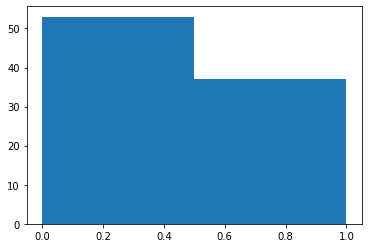

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
_ = plt.hist(nn_preds_clean, bins=2)